In [1]:
import datetime # для работы со времнем
import gc # сборщик мусора

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

#import xgboost as xgb
#from lightgbm import LGBMRegressor

%matplotlib inline

# 1. Чтение данных

In [2]:
df = pd.read_csv('Downloads/realestatepriceprediction/train.csv')

X = df.drop('Price', axis=1)
y = df[['Price']]
X2 = X.copy()


X_final = pd.read_csv('Downloads/realestatepriceprediction/test.csv')

# сразу создам
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

# Удалим ненужные файлы
del df
gc.collect()  

Строк в трейне: 10000
Строк в тесте 5000


0

In [3]:
X.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B


In [4]:
X['DistrictId'] = X['DistrictId'].astype(str)
X_final['DistrictId'] = X_final['DistrictId'].astype(str)

# 1. Минимальный EDA

# **Делайем EDA не просто так, а для:
- Исправления выбросов
- Заполнения NaN
- Идей для генерации новых фич

# 1.1 Выбросы

In [5]:
X2['Square'].mean()


56.31577519793556

In [6]:
X2['Ecology_1'].min()

0.0

In [7]:
X2.loc[X2['Square']<17]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
212,1748,88,2.0,5.497061,67.628717,1.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B
1316,11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B
1608,10202,6,1.0,2.596351,4.604943,1.0,3,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B
3280,10527,27,1.0,4.380726,40.805837,1.0,10,17.0,2013,0.211401,B,B,9,1892,0,NaN,0,1,B
3413,9487,5,1.0,5.129222,5.549458,1.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B
4739,12676,81,3.0,13.784865,15.988889,7.0,4,5.0,1960,0.319809,B,B,25,4756,16,2857.0,5,8,B
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B
4900,4504,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B
5617,15877,57,3.0,16.547242,16.698571,8.0,5,5.0,1962,0.133215,B,B,49,11395,3,1406.0,3,4,A
6392,14786,1,1.0,1.136859,4.525736,1.0,3,1.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B


In [8]:
X2['RoomSquare']=X2['Square']/(X2['Rooms']+2)

In [9]:
X2['RoomSquare']

0       11.995390
1       13.136728
2       11.236988
3       13.338245
4       13.216397
          ...    
9995    12.600446
9996    13.840515
9997    15.979669
9998    10.900640
9999    12.888882
Name: RoomSquare, Length: 10000, dtype: float64

In [10]:
X2['Social_1']

0       33
1       46
2       34
3       23
4       35
        ..
9995    46
9996    30
9997     2
9998    30
9999    27
Name: Social_1, Length: 10000, dtype: int64

In [11]:
X2.loc[(X2['RoomSquare'] < 10) & (X2['Rooms'] > 1 )]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,RoomSquare
30,89,50,2.0,39.435351,23.377687,7.0,9,9.0,1965,0.007659,B,B,35,7077,56,2301.0,3,19,B,9.858838
111,12428,94,2.0,39.900425,26.477223,6.0,12,14.0,1982,0.282798,B,B,33,8667,2,NaN,0,6,B,9.975106
212,1748,88,2.0,5.497061,67.628717,1.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,1.374265
311,16497,49,2.0,39.003737,23.938135,6.0,10,9.0,1965,0.020741,B,B,24,5613,5,1340.0,2,5,B,9.750934
312,7383,84,2.0,38.012225,27.777619,5.0,3,9.0,1965,0.006076,B,B,30,5285,0,645.0,6,6,B,9.503056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9491,3216,50,2.0,39.902317,23.675978,7.0,3,9.0,1963,0.007659,B,B,35,7077,56,2301.0,3,19,B,9.975579
9905,6547,113,2.0,39.611616,27.430691,6.0,2,9.0,1966,0.060753,B,B,15,2787,2,520.0,0,7,B,9.902904
9955,2288,137,2.0,39.381630,24.092106,7.0,7,9.0,1965,0.049863,B,B,18,3746,9,75.0,3,1,B,9.845407
9964,10463,27,3.0,49.574590,45.590573,1.0,18,25.0,2013,0.072158,B,B,2,629,1,NaN,0,0,A,9.914918


In [12]:
X2['RoomSquare2']=X2['LifeSquare']/X2['Rooms']

In [13]:
X2['RoomSquare2']

0       14.721375
1       13.349848
2       14.598806
3       26.365756
4       23.776169
          ...    
9995    15.238102
9996    20.539216
9997          NaN
9998    16.920074
9999    21.157874
Name: RoomSquare2, Length: 10000, dtype: float64

In [14]:
X2['RoomSquare2'].mean()

inf

In [15]:
X3=X2.loc[(X2['Square']/X2['Rooms']+2)<X2['KitchenSquare']]
X3.info()
X3.head(100)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 227 to 9895
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             26 non-null     int64  
 1   DistrictId     26 non-null     int64  
 2   Rooms          26 non-null     float64
 3   Square         26 non-null     float64
 4   LifeSquare     25 non-null     float64
 5   KitchenSquare  26 non-null     float64
 6   Floor          26 non-null     int64  
 7   HouseFloor     26 non-null     float64
 8   HouseYear      26 non-null     int64  
 9   Ecology_1      26 non-null     float64
 10  Ecology_2      26 non-null     object 
 11  Ecology_3      26 non-null     object 
 12  Social_1       26 non-null     int64  
 13  Social_2       26 non-null     int64  
 14  Social_3       26 non-null     int64  
 15  Healthcare_1   10 non-null     float64
 16  Helthcare_2    26 non-null     int64  
 17  Shops_1        26 non-null     int64  
 18  Shops_2 

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,RoomSquare,RoomSquare2
227,16395,2,3.0,79.722243,44.731219,72.0,12,16.0,1987,0.130618,...,B,39,10418,9,900.0,1,9,B,15.944449,14.910406
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,...,B,74,19083,2,NaN,5,15,B,4.921415,3.622307
1064,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,...,B,2,629,1,NaN,0,0,A,15.700240,46.447960
1369,2371,27,2.0,68.841073,64.234956,66.0,4,2.0,2014,0.017647,...,B,2,469,0,NaN,0,0,B,17.210268,32.117478
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,...,B,1,264,0,NaN,0,1,B,2.000288,1.146278
1455,12507,54,2.0,79.810535,79.578961,78.0,10,15.0,2014,0.006076,...,B,30,5285,0,645.0,6,6,B,19.952634,39.789481
1860,4265,161,2.0,53.216778,32.644859,53.0,7,17.0,1994,0.000699,...,B,14,3369,24,4129.0,0,3,B,13.304194,16.322429
2916,12390,72,3.0,97.490674,99.323558,96.0,22,25.0,2019,0.210473,...,B,11,2398,2,1994.0,3,0,B,19.498135,33.107853
2969,7441,62,3.0,114.734473,112.589083,112.0,3,3.0,2015,0.072158,...,B,2,629,1,NaN,0,0,A,22.946895,37.529694
4079,6508,23,2.0,67.146049,33.959154,63.0,5,17.0,2019,0.034656,...,B,0,168,0,NaN,0,0,B,16.786512,16.979577


In [16]:
X2.loc[(X2['KitchenSquare']<4) & (X2['Square']>20)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,RoomSquare,RoomSquare2
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,B,34,7759,0,229.0,1,3,B,11.236988,14.598806
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,20.078231,NaN
8,5172,1,2.0,64.511437,NaN,1.0,9,17.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,16.127859,NaN
12,6452,13,2.0,54.522805,31.759753,1.0,8,12.0,1999,0.090799,...,B,74,19083,2,NaN,5,15,B,13.630701,15.879877
14,10953,27,1.0,53.769097,52.408027,1.0,5,4.0,1977,0.072158,...,B,2,629,1,NaN,0,0,A,17.923032,52.408027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,16159,27,1.0,38.968338,NaN,1.0,10,1.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,12.989446,NaN
9986,2996,1,2.0,64.994245,NaN,1.0,9,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,16.248561,NaN
9987,15623,23,2.0,55.620092,NaN,0.0,2,4.0,1977,0.034656,...,B,0,168,0,NaN,0,0,B,13.905023,NaN
9994,4158,23,2.0,64.864198,NaN,1.0,17,17.0,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,16.216050,NaN


In [17]:
X2.loc[(X2['Square']/X2['Rooms'])<X2['KitchenSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,RoomSquare,RoomSquare2
227,16395,2,3.0,79.722243,44.731219,72.0,12,16.0,1987,0.130618,...,B,39,10418,9,900.0,1,9,B,15.944449,14.910406
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,...,B,74,19083,2,NaN,5,15,B,4.921415,3.622307
1064,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,...,B,2,629,1,NaN,0,0,A,15.700240,46.447960
1369,2371,27,2.0,68.841073,64.234956,66.0,4,2.0,2014,0.017647,...,B,2,469,0,NaN,0,0,B,17.210268,32.117478
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,...,B,1,264,0,NaN,0,1,B,2.000288,1.146278
1455,12507,54,2.0,79.810535,79.578961,78.0,10,15.0,2014,0.006076,...,B,30,5285,0,645.0,6,6,B,19.952634,39.789481
1860,4265,161,2.0,53.216778,32.644859,53.0,7,17.0,1994,0.000699,...,B,14,3369,24,4129.0,0,3,B,13.304194,16.322429
2916,12390,72,3.0,97.490674,99.323558,96.0,22,25.0,2019,0.210473,...,B,11,2398,2,1994.0,3,0,B,19.498135,33.107853
2969,7441,62,3.0,114.734473,112.589083,112.0,3,3.0,2015,0.072158,...,B,2,629,1,NaN,0,0,A,22.946895,37.529694
4079,6508,23,2.0,67.146049,33.959154,63.0,5,17.0,2019,0.034656,...,B,0,168,0,NaN,0,0,B,16.786512,16.979577


In [18]:
X2['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
41.0         2
112.0        2
25.0         2
43.0         2
51.0         2
37.0         2
32.0         2
30.0         2
58.0         2
72.0         1
96.0         1
66.0         1
48.0         1
40.0         1
2014.0       1
35.0         1
60.0         1
78.0         1
27.0         1
84.0         1
62.0         1
42.0         1
63.0         1
39.0         1
1970.0       1
36.0         1
75.0         1
26.0         1
21.0         1
29.0         1
23.0         1
73.0         1
123.0        1
31.0         1
53.0         1
54.0         1
Name: KitchenSquare, dtype: int64

In [19]:
X.dtypes

DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

# **Rooms**

In [20]:
X['Rooms'].value_counts()

# > 6 комнат, = 0 комнат

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [21]:
X2.loc[(X2['Rooms'] == 0) | (X2['Rooms'] > 5)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,RoomSquare,RoomSquare2
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,...,B,74,19083,2,NaN,5,15,B,4.921415,3.622307
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,...,B,11,3097,0,NaN,0,0,B,69.213847,inf
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,...,B,1,264,0,NaN,0,1,B,2.000288,1.146278
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,...,B,9,1892,0,NaN,0,1,B,106.466181,inf
2170,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,...,B,66,10573,1,1322.0,3,8,B,7.426792,6.450374
2269,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,20.895441,NaN
3911,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,...,B,30,6207,1,1183.0,1,0,B,24.741751,NaN
4366,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,...,B,5,1564,0,540.0,0,0,B,40.745723,NaN
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,...,B,2,469,0,NaN,0,0,B,1.188624,inf
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,...,B,43,8429,3,NaN,3,9,B,19.348559,inf


In [22]:
X2.loc[X2['Rooms'] == 5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,RoomSquare,RoomSquare2
1422,4282,195,5.0,95.617533,62.377052,7.0,7,7.0,1940,0.015017,...,B,17,3079,59,2890.0,0,8,B,13.659648,12.475410
1503,1243,86,5.0,108.057398,82.723825,8.0,3,5.0,1942,0.161976,...,A,31,7010,5,4508.0,3,7,B,15.436771,16.544765
1982,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,...,A,31,7010,5,4508.0,3,7,B,39.377898,46.789862
3268,8901,34,5.0,121.577423,114.913843,1.0,25,1.0,1977,0.069753,...,B,53,13670,4,NaN,1,11,B,17.368203,22.982769
3271,6358,27,5.0,42.003293,NaN,0.0,5,12.0,1977,0.011654,...,B,4,915,0,NaN,0,0,B,6.000470,NaN
4431,7594,53,5.0,39.906082,39.394024,1.0,5,1.0,1977,0.049637,...,B,34,7759,0,229.0,1,3,B,5.700869,7.878805
4487,13434,13,5.0,183.382273,100.985505,15.0,2,6.0,1997,0.090799,...,B,74,19083,2,NaN,5,15,B,26.197468,20.197101
4762,4070,21,5.0,114.313752,88.492650,9.0,6,5.0,1960,0.034331,...,B,25,5487,3,NaN,0,4,B,16.330536,17.698530
5361,2879,78,5.0,118.871952,69.023509,10.0,15,16.0,1998,0.092291,...,B,21,4346,2,165.0,1,2,B,16.981707,13.804702
5466,3454,8,5.0,112.135525,79.795451,10.0,4,17.0,1999,0.437885,...,B,23,5735,3,1084.0,0,5,B,16.019361,15.959090


In [23]:
X['KitchenSquare'].value_counts().sort_values()

# Площадь < 3
# Площадь > 1000

54.0         1
72.0         1
96.0         1
66.0         1
48.0         1
40.0         1
2014.0       1
35.0         1
60.0         1
78.0         1
27.0         1
84.0         1
42.0         1
62.0         1
39.0         1
1970.0       1
36.0         1
75.0         1
26.0         1
21.0         1
29.0         1
23.0         1
73.0         1
123.0        1
31.0         1
63.0         1
53.0         1
30.0         2
58.0         2
32.0         2
51.0         2
43.0         2
25.0         2
112.0        2
41.0         2
37.0         2
22.0         3
2.0          4
18.0         6
19.0        11
17.0        12
20.0        14
16.0        16
3.0         22
15.0        31
4.0         39
14.0        51
13.0        67
11.0       233
12.0       249
7.0        609
0.0        697
9.0        843
6.0       1038
10.0      1075
5.0       1169
8.0       1306
1.0       2460
Name: KitchenSquare, dtype: int64

In [24]:
X2.groupby(['HouseYear'], as_index=False).agg({'KitchenSquare':'median'})

,HouseYear,KitchenSquare
0,1910,20.0
1,1912,20.5
2,1914,7.0
3,1916,14.0
4,1917,9.0
...,...,...
92,2018,1.0
93,2019,8.0
94,2020,10.0
95,4968,5.0


# **Floor, HouseFloor**

In [25]:
X['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [26]:
X['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [27]:
(X['Floor'] > X['HouseFloor']).sum()

1825

In [28]:
X2.loc[X2['Floor'] > X2['HouseFloor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,RoomSquare,RoomSquare2
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,20.078231,NaN
14,10953,27,1.0,53.769097,52.408027,1.0,5,4.0,1977,0.072158,...,B,2,629,1,NaN,0,0,A,17.923032,52.408027
16,2119,27,2.0,49.360648,31.993964,5.0,6,5.0,1983,0.051815,...,B,5,1227,0,NaN,0,0,B,12.340162,15.996982
21,11935,27,2.0,64.711835,NaN,1.0,15,1.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,16.177959,NaN
23,6641,54,3.0,118.907612,NaN,0.0,2,0.0,1977,0.006076,...,B,30,5285,0,645.0,6,6,B,23.781522,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984,2237,52,3.0,64.074977,47.633428,6.0,11,9.0,1983,0.371149,...,B,34,7065,1,750.0,2,5,B,12.814995,15.877809
9985,16159,27,1.0,38.968338,NaN,1.0,10,1.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,12.989446,NaN
9989,4145,96,3.0,90.055233,47.860231,11.0,26,24.0,2005,0.041116,...,B,53,14892,4,NaN,1,4,B,18.011047,15.953410
9991,11553,3,3.0,101.622794,51.628780,12.0,18,17.0,2000,0.265089,...,B,37,5288,0,1937.0,3,2,B,20.324559,17.209593


In [29]:
X2.loc[X2['Floor'] > X2['HouseFloor'],'Floor_outlier']= X2['Floor']

In [30]:
X2.loc[X2['Floor_outlier'] > 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,RoomSquare,RoomSquare2,Floor_outlier
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,...,6,1437,3,NaN,0,2,B,20.078231,NaN,14.0
14,10953,27,1.0,53.769097,52.408027,1.0,5,4.0,1977,0.072158,...,2,629,1,NaN,0,0,A,17.923032,52.408027,5.0
16,2119,27,2.0,49.360648,31.993964,5.0,6,5.0,1983,0.051815,...,5,1227,0,NaN,0,0,B,12.340162,15.996982,6.0
21,11935,27,2.0,64.711835,NaN,1.0,15,1.0,1977,0.211401,...,9,1892,0,NaN,0,1,B,16.177959,NaN,15.0
23,6641,54,3.0,118.907612,NaN,0.0,2,0.0,1977,0.006076,...,30,5285,0,645.0,6,6,B,23.781522,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984,2237,52,3.0,64.074977,47.633428,6.0,11,9.0,1983,0.371149,...,34,7065,1,750.0,2,5,B,12.814995,15.877809,11.0
9985,16159,27,1.0,38.968338,NaN,1.0,10,1.0,1977,0.211401,...,9,1892,0,NaN,0,1,B,12.989446,NaN,10.0
9989,4145,96,3.0,90.055233,47.860231,11.0,26,24.0,2005,0.041116,...,53,14892,4,NaN,1,4,B,18.011047,15.953410,26.0
9991,11553,3,3.0,101.622794,51.628780,12.0,18,17.0,2000,0.265089,...,37,5288,0,1937.0,3,2,B,20.324559,17.209593,18.0


In [31]:
X2.loc[X2['Floor_outlier'] > 0,'Floor']=X2['HouseFloor']

In [32]:
X2.loc[X2['Floor_outlier'] > 0,'HouseFloor']=X2['Floor_outlier']

In [33]:
X2.loc[X2['Floor_outlier'] > 0,'Floor_outlier']=1

In [34]:
X2.loc[X2['Floor_outlier'] > 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,RoomSquare,RoomSquare2,Floor_outlier
7,11993,74,2.0,80.312926,NaN,0.0,0.0,14.0,1977,0.075779,...,6,1437,3,NaN,0,2,B,20.078231,NaN,1.0
14,10953,27,1.0,53.769097,52.408027,1.0,4.0,5.0,1977,0.072158,...,2,629,1,NaN,0,0,A,17.923032,52.408027,1.0
16,2119,27,2.0,49.360648,31.993964,5.0,5.0,6.0,1983,0.051815,...,5,1227,0,NaN,0,0,B,12.340162,15.996982,1.0
21,11935,27,2.0,64.711835,NaN,1.0,1.0,15.0,1977,0.211401,...,9,1892,0,NaN,0,1,B,16.177959,NaN,1.0
23,6641,54,3.0,118.907612,NaN,0.0,0.0,2.0,1977,0.006076,...,30,5285,0,645.0,6,6,B,23.781522,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984,2237,52,3.0,64.074977,47.633428,6.0,9.0,11.0,1983,0.371149,...,34,7065,1,750.0,2,5,B,12.814995,15.877809,1.0
9985,16159,27,1.0,38.968338,NaN,1.0,1.0,10.0,1977,0.211401,...,9,1892,0,NaN,0,1,B,12.989446,NaN,1.0
9989,4145,96,3.0,90.055233,47.860231,11.0,24.0,26.0,2005,0.041116,...,53,14892,4,NaN,1,4,B,18.011047,15.953410,1.0
9991,11553,3,3.0,101.622794,51.628780,12.0,17.0,18.0,2000,0.265089,...,37,5288,0,1937.0,3,2,B,20.324559,17.209593,1.0


In [35]:
X2.loc[(X2['LifeSquare'] < X2['RoomSquare'] * (X2['Rooms']-1)) & (X2['LifeSquare']>10)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,RoomSquare,RoomSquare2,Floor_outlier
377,5927,57,10.0,59.056975,36.223072,10.0,22.0,22.0,2002,0.090799,...,74,19083,2,NaN,5,15,B,4.921415,3.622307,NaN
1454,8491,1,19.0,42.006046,21.779288,7.0,17.0,17.0,2014,0.007122,...,1,264,0,NaN,0,1,B,2.000288,1.146278,NaN
3723,203,33,4.0,101.554252,22.630373,9.0,4.0,5.0,1958,0.051942,...,17,4017,7,800.0,2,0,B,16.925709,5.657593,NaN
4487,13434,13,5.0,183.382273,100.985505,15.0,2.0,6.0,1997,0.090799,...,74,19083,2,NaN,5,15,B,26.197468,20.197101,NaN
5057,1194,75,3.0,74.969645,27.938423,9.0,11.0,15.0,1999,0.122090,...,29,6566,7,1894.0,4,0,B,14.993929,9.312808,NaN
5087,15947,129,4.0,185.906396,84.830074,31.0,3.0,5.0,2015,0.020741,...,24,5613,5,1340.0,2,5,B,30.984399,21.207519,1.0
5786,7857,27,2.0,43.956044,10.523868,19.0,15.0,17.0,2006,0.075424,...,11,3097,0,NaN,0,0,B,10.989011,5.261934,NaN
6451,3914,24,4.0,155.930023,76.831293,15.0,6.0,22.0,2012,0.111627,...,50,12238,8,1970.0,2,3,B,25.988337,19.207823,NaN
7201,3233,129,4.0,186.692602,87.487080,32.0,3.0,3.0,2011,0.020741,...,24,5613,5,1340.0,2,5,B,31.115434,21.871770,NaN
8551,13772,96,4.0,44.128947,18.212628,10.0,10.0,13.0,2005,0.041116,...,53,14892,4,NaN,1,4,B,7.354824,4.553157,NaN


In [36]:
X2.loc[ (X2['LifeSquare'] < X2['Square']/3) & (X2['LifeSquare']>10)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,RoomSquare,RoomSquare2,Floor_outlier
1186,1428,27,1.0,62.973855,19.795411,19.0,4.0,6.0,1977,0.075424,...,11,3097,0,NaN,0,0,B,20.991285,19.795411,NaN
1526,16559,75,2.0,60.610730,17.225296,5.0,5.0,5.0,1964,0.122090,...,29,6566,7,1894.0,4,0,B,15.152683,8.612648,NaN
1972,15691,62,1.0,41.735073,12.423180,14.0,3.0,15.0,2010,0.072158,...,2,629,1,NaN,0,0,A,13.911691,12.423180,NaN
3723,203,33,4.0,101.554252,22.630373,9.0,4.0,5.0,1958,0.051942,...,17,4017,7,800.0,2,0,B,16.925709,5.657593,NaN
5232,5826,23,1.0,55.282148,11.168019,20.0,3.0,4.0,2013,0.014073,...,2,475,0,NaN,0,0,B,18.427383,11.168019,1.0
5494,300,31,2.0,106.427686,34.230415,32.0,4.0,40.0,2013,0.151346,...,32,5889,10,830.0,4,1,B,26.606922,17.115207,NaN
5653,8500,31,1.0,80.606246,25.299592,29.0,6.0,40.0,2014,0.151346,...,32,5889,10,830.0,4,1,B,26.868749,25.299592,NaN
5786,7857,27,2.0,43.956044,10.523868,19.0,15.0,17.0,2006,0.075424,...,11,3097,0,NaN,0,0,B,10.989011,5.261934,NaN
8906,4682,7,2.0,43.860149,11.321071,7.0,6.0,12.0,1969,0.035145,...,42,9292,3,2620.0,0,3,B,10.965037,5.660536,NaN
9317,13288,161,1.0,50.808925,15.920343,20.0,8.0,9.0,1910,0.014423,...,19,3806,4,NaN,0,3,B,16.936308,15.920343,NaN


In [37]:
X2.loc[(X2['Square']*0.5 < X2['KitchenSquare'] )  & (X2['KitchenSquare']>10)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,RoomSquare,RoomSquare2,Floor_outlier
227,16395,2,3.0,79.722243,44.731219,72.0,12.0,16.0,1987,0.130618,...,39,10418,9,900.0,1,9,B,15.944449,14.910406,NaN
551,1315,6,1.0,48.128114,45.023531,48.0,1.0,21.0,2013,0.243205,...,5,1564,0,540.0,0,0,B,16.042705,45.023531,1.0
1064,14656,62,1.0,47.100719,46.447960,2014.0,1.0,4.0,2014,0.072158,...,2,629,1,NaN,0,0,A,15.700240,46.447960,1.0
1077,9690,27,1.0,40.081042,37.834964,37.0,18.0,19.0,2019,0.211401,...,9,1892,0,NaN,0,1,B,13.360347,37.834964,NaN
1369,2371,27,2.0,68.841073,64.234956,66.0,2.0,4.0,2014,0.017647,...,2,469,0,NaN,0,0,B,17.210268,32.117478,1.0
1455,12507,54,2.0,79.810535,79.578961,78.0,10.0,15.0,2014,0.006076,...,30,5285,0,645.0,6,6,B,19.952634,39.789481,NaN
1860,4265,161,2.0,53.216778,32.644859,53.0,7.0,17.0,1994,0.000699,...,14,3369,24,4129.0,0,3,B,13.304194,16.322429,NaN
2916,12390,72,3.0,97.490674,99.323558,96.0,22.0,25.0,2019,0.210473,...,11,2398,2,1994.0,3,0,B,19.498135,33.107853,NaN
2969,7441,62,3.0,114.734473,112.589083,112.0,3.0,3.0,2015,0.072158,...,2,629,1,NaN,0,0,A,22.946895,37.529694,NaN
3379,16781,27,1.0,36.138409,36.710539,36.0,19.0,19.0,2017,0.072158,...,2,629,1,NaN,0,0,A,12.046136,36.710539,NaN


# **HouseYear**

In [38]:
X_final['HouseYear'].min()

1908

# Заполнение NaN

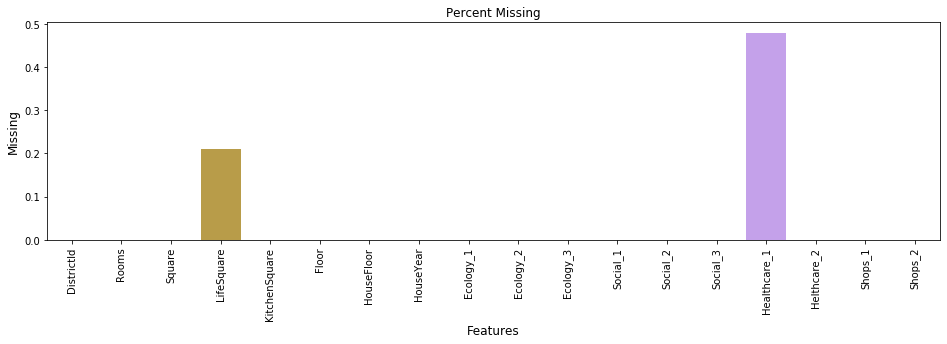

In [39]:
import seaborn as sns

nan_df = (X.isna().sum() / X.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

# Удалим Healthcare_1
# Заполним LifeSquare

# * ### 1.2 Feature engineering

**DistrictId**

In [40]:
X.DistrictId.nunique()

205

In [41]:
dict(X['DistrictId'].value_counts())

{'27': 851,
 '1': 652,
 '23': 565,
 '6': 511,
 '9': 294,
 '62': 247,
 '30': 228,
 '58': 179,
 '53': 174,
 '21': 165,
 '52': 143,
 '8': 142,
 '11': 129,
 '46': 119,
 '61': 118,
 '45': 116,
 '74': 114,
 '34': 111,
 '57': 107,
 '44': 104,
 '13': 97,
 '99': 97,
 '47': 97,
 '101': 97,
 '7': 92,
 '48': 90,
 '29': 89,
 '94': 89,
 '41': 87,
 '3': 82,
 '84': 80,
 '28': 79,
 '22': 78,
 '2': 78,
 '25': 77,
 '85': 76,
 '93': 73,
 '90': 72,
 '37': 72,
 '96': 71,
 '59': 67,
 '75': 66,
 '26': 65,
 '12': 64,
 '88': 64,
 '128': 64,
 '66': 62,
 '67': 61,
 '17': 59,
 '55': 58,
 '39': 57,
 '10': 56,
 '31': 55,
 '105': 55,
 '18': 51,
 '111': 49,
 '119': 49,
 '0': 48,
 '78': 46,
 '91': 44,
 '63': 43,
 '124': 43,
 '129': 43,
 '79': 42,
 '42': 42,
 '109': 41,
 '113': 41,
 '77': 40,
 '54': 37,
 '38': 36,
 '15': 36,
 '24': 35,
 '5': 34,
 '32': 34,
 '56': 34,
 '103': 33,
 '123': 32,
 '19': 31,
 '83': 31,
 '33': 31,
 '80': 31,
 '130': 29,
 '138': 29,
 '69': 29,
 '64': 28,
 '86': 27,
 '87': 27,
 '70': 27,
 '108': 

# 2. Очистка данных

In [42]:
X2.loc[(X2['Square'] < 16) & (X2['LifeSquare'] > X2['Square']) & (X2['LifeSquare'] > 10),'Square']

212      5.497061
3280     4.380726
4739    13.784865
8030     4.823679
Name: Square, dtype: float64

In [43]:
X2['Healthcare_1'].head()

0       NaN
1     240.0
2     229.0
3    1084.0
4    2078.0
Name: Healthcare_1, dtype: float64

In [44]:
class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()
    
    def transform(self, X):
        
        #Square
        #X.loc[X['Square'] < 16, 'Square'] = 3
        X.loc[(X['Square'] < 15) & (X['LifeSquare'] > X['Square']) & (X['LifeSquare'] > 10),'Square']=X['LifeSquare']+self.medians['KitchenSquare']  
        X.loc[(X['Square'] < 11) & (X['LifeSquare'] > X['Square']) & (X['LifeSquare'] <= 10),'Square']=X['LifeSquare']*10+self.medians['KitchenSquare'] 
        X.loc[(X['Square'] < 11) & (X['LifeSquare'] <= X['Square']),'Square']=X['Square']*10 
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] > 5, 'Rooms'] = round(self.medians['Rooms']) # !!! медиана посчитана на трейне !!!
        
        #room square
        X['RoomSquare']=X['Square']/(X['Rooms']+2)
        # Rooms
        #X['mRooms'] = round(self.medians['Rooms'])
        #X['mSquare'] = round(self.medians['Square'])
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        X.loc[(X['RoomSquare']<8) & (X['Rooms']>1) & (X['RoomSquare']<X['KitchenSquare']),'Rooms'] = 1
        X.loc[(X['RoomSquare']<5) & (X['Rooms']>1) ,'Rooms'] = 1
        X['RoomSquare']=X['Square']/(X['Rooms']+2)
        
        # KitchenSquare
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        #X.loc[(X['KitchenSquare'] > X['Square']) & (X['Square']>10), 'KitchenSquare'] = X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] / 10  # можно median
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['Floor'] > X['HouseFloor'],'HouseFloor_outlier']= X['Floor']
        X.loc[X['HouseFloor_outlier'] > 0,'Floor']=X['HouseFloor']
        X.loc[X['HouseFloor_outlier'] > 0,'HouseFloor']=X['HouseFloor_outlier']
        X.loc[X['HouseFloor_outlier'] > 0,'HouseFloor_outlier']=1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        #X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        #X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']
        
        # HouseYear
        current_year = now = datetime.datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        X.loc[X['HouseYear'] < 1900, 'HouseYear_outlier'] = 1
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = 1900
        
        # Healthcare_1
        #if 'Healthcare_1' in X.columns:
        #    X.drop('Healthcare_1', axis=1, inplace=True)
        X['Healthcare_nan'] = X['Healthcare_1'].isna() * 1 
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] = self.medians['Healthcare_1'] 
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        
        
        condition = (X['LifeSquare'].isna()) &\
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        X.loc[(X['LifeSquare']<10) & (X['LifeSquare']>0),'LifeSquare']=X['LifeSquare']*10
        
        
        return X
        

In [45]:
imputer = FeatureImputer()

imputer.fit(X) # расчет медиан

X = imputer.transform(X)
X_final = imputer.transform(X_final)

In [46]:
X.loc[(X['RoomSquare']<8) & (X['Rooms']>1)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,RoomSquare,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,Healthcare_nan,LifeSquare_nan
Id,,,,,,,,,,,,,,,,,,,,,
16772,109,3.0,32.795221,36.659413,6.0,2.0,9.0,1979,0.136330,B,...,262.0,3,6,B,6.559044,0,0,0,0,0
6358,27,5.0,42.003293,36.003293,3.0,5.0,12.0,1977,0.011654,B,...,900.0,0,0,B,6.000470,0,0,0,1,1
7594,53,5.0,39.906082,39.394024,3.0,1.0,5.0,1977,0.049637,B,...,229.0,1,3,B,5.700869,0,1,0,0,0
1392,30,3.0,39.596076,41.832097,3.0,2.0,5.0,1977,0.000078,B,...,1046.0,3,23,B,7.919215,0,0,0,0,0
4352,104,2.0,28.517666,15.565872,3.0,6.0,7.0,1931,0.000078,B,...,1046.0,3,23,B,7.129416,0,1,0,0,0
3052,1,3.0,31.113950,19.799743,6.0,5.0,6.0,1975,0.014581,B,...,900.0,0,0,B,6.222790,0,1,0,1,0


In [47]:
X.loc[X['Square']<16]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,RoomSquare,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,Healthcare_nan,LifeSquare_nan
Id,,,,,,,,,,,,,,,,,,,,,


In [48]:
X_final.loc[X_final['Square']<16]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,RoomSquare,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,Healthcare_nan,LifeSquare_nan
Id,,,,,,,,,,,,,,,,,,,,,
9011,53,1.0,13.785426,13.535731,3.0,1.0,1.0,1977,0.049637,B,...,229.0,1,3,B,4.595142,0,0,0,0,0
15435,21,1.0,13.305531,94.953672,3.0,5.0,6.0,1965,0.194489,B,...,125.0,3,5,B,4.435177,0,1,0,0,0


# 3. Feature engineering

In [49]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.Years_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = 0
        self.med_price_by_yeardistrict = 0
        self.med_price_by_floordistrict = 0
        self.med_price_by_floor_year = 0
        self.med_room_by_distric = 0
        self.med_square_by_distric = 0
        self.med_kitchen_by_distric = 0
        self.med_health_by_distric = 0
        self.med_price_by_healthdistrict = 0
        self.med_price_by_socialdistrict = 0
        self.med_price_by_ecologydistrict = 0
        self.med_pricem2_by_distric = 0
        
    def fit(self, X, y=None):
            
        X = X.copy()
        
        #medians
        self.medians = X.median()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 5]  ## Если вы этого не сделаете, то на Leaderboard-е улетите в самый низ (>100 места, R2 ~ 0.65),
                                            ## Хотя на локальной валидации скор вырастет
        
        self.DistrictId_counts = dict(district)
        
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Target encoding
        ## District
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            self.med_price_by_district=0
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                        rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            
        ## floor, year
        #df['MedPriceByFloorYear']=0
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            
            years = df['year_cat'].value_counts()
            years = years[years > 5] 
            df.loc[~df['year_cat'].isin(years.keys().tolist())] = np.nan
        
            self.med_price_by_floor_year=0
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            
        if y is not None:
            df['Price'] = y.values
            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            years = df['year_cat'].value_counts()
            years = years[years > 10] 
            df.loc[~df['year_cat'].isin(years.keys().tolist())] = np.nan
            
            self.med_price_by_yeardistrict=0
            self.med_price_by_yeardistrict = df.groupby(['DistrictId_popular', 'year_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByYearDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            
        if y is not None:
            df['Price'] = y.values
            
            #df['DistrictId_popular'] = df['DistrictId'].copy()
            #df = self.year_to_cat(df)
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_floordistrict=0
            self.med_price_by_floordistrict = df.groupby(['DistrictId_popular', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorDistrict',
                                                           'DistrictId_popular': 'DistrictId'})

        if y is not None:
            df['Price'] = y.values
            
            #df['DistrictId_popular'] = df['DistrictId'].copy()
            df = self.health_to_cat(df)
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            self.med_price_by_healthdistrict=0
            self.med_price_by_healthdistrict = df.groupby(['DistrictId_popular', 'health_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByHealthDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
        
        if y is not None:
            df['Price'] = y.values
            
            #df['DistrictId_popular'] = df['DistrictId'].copy()
            df = self.social_to_cat(df)
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            self.med_price_by_socialdistrict=0
            self.med_price_by_socialdistrict = df.groupby(['DistrictId_popular', 'social_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySocialDistrict',
                                                           'DistrictId_popular': 'DistrictId'})

        if y is not None:
            df['Price'] = y.values
            
            #df['DistrictId_popular'] = df['DistrictId'].copy()
            df = self.ecology_to_cat(df)
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            self.med_price_by_ecologydistrict=0
            self.med_price_by_ecologydistrict = df.groupby(['DistrictId_popular', 'ecology_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByEcologyDistrict',
                                                           'DistrictId_popular': 'DistrictId'})

 
        
        self.med_room_by_distric = round(df.groupby(['DistrictId'], as_index=False).agg({'Rooms':'median'}).\
                                    rename(columns={'Rooms':'mRooms'}))
        
        self.med_square_by_distric = round(df.groupby(['DistrictId'], as_index=False).agg({'Square':'median'}).\
                                    rename(columns={'Square':'mSquare'}))
        
        self.med_kitchen_by_distric = round(df.groupby(['DistrictId'], as_index=False).agg({'KitchenSquare':'median'}).\
                                    rename(columns={'KitchenSquare':'mKitchenSquare'}))
        
        self.med_health_by_distric = round(df.groupby(['DistrictId'], as_index=False).agg({'Healthcare_1':'median'}).\
                                    rename(columns={'Healthcare_1':'mHealth'}))
        
      #  if y is not None:
      #      df['Price'] = y.values
      #      df['M2Price'] = df['Price']/df['Square']
      #      self.med_pricem2_by_distric = round(df.groupby(['DistrictId'], as_index=False).agg({'M2Price':'median'}).\
      #                              rename(columns={'M2Price':'mM2Price'}))

        if y is not None:
            df['Price'] = y.values
            df['M2Price'] = df['Price']/df['Square']
            #df['DistrictId_popular'] = df['DistrictId'].copy()
            #df = self.year_to_cat(df)
            df.loc[~df['DistrictId'].isin(district.keys().tolist())] = np.nan
            self.med_pricem2_by_distric=0
            self.med_pricem2_by_distric = df.groupby(['DistrictId', 'year_cat'], as_index=False).agg({'M2Price':'median'}).\
                                            rename(columns={'M2Price':'MedM2PriceByYearDistrict'})
            
        
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)  # self.DistrictId_counts = {'id': value}
        #X['mRooms'] = X.groupby(['DistrictId'], as_index=False).agg({'Rooms':'median'})  # self.DistrictId_counts = {'id': value}
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(5, inplace=True)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        X = self.health_to_cat(X)   # + столбец health_cat
        X = self.social_to_cat(X)   # + столбец social_cat
        X = self.ecology_to_cat(X)   # + столбец ecology_cat
        

        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        X['MedPriceByDistrict'].fillna(0, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        X['MedPriceByFloorYear'].fillna(0, inplace=True)
        
        if self.med_price_by_yeardistrict is not None:
            X = X.merge(self.med_price_by_yeardistrict, on=['DistrictId', 'year_cat'], how='left')
        X['MedPriceByYearDistrict'].fillna(0, inplace=True)
        
        if self.med_price_by_floordistrict is not None:
            X = X.merge(self.med_price_by_floordistrict, on=['DistrictId', 'floor_cat'], how='left')
        X['MedPriceByFloorDistrict'].fillna(0, inplace=True)
        
        if self.med_price_by_healthdistrict is not None:
            X = X.merge(self.med_price_by_healthdistrict, on=['DistrictId', 'health_cat'], how='left')
        X['MedPriceByHealthDistrict'].fillna(0, inplace=True)

        if self.med_price_by_socialdistrict is not None:
            X = X.merge(self.med_price_by_socialdistrict, on=['DistrictId', 'social_cat'], how='left')
        X['MedPriceBySocialDistrict'].fillna(0, inplace=True)

        
        if self.med_price_by_ecologydistrict is not None:
            X = X.merge(self.med_price_by_ecologydistrict, on=['DistrictId', 'ecology_cat'], how='left')
        X['MedPriceByEcologyDistrict'].fillna(0, inplace=True)
        
        if self.med_room_by_distric is not None:
            X = X.merge(self.med_room_by_distric, on=['DistrictId'], how='left')
        X['mRooms'].fillna(round(self.medians['Rooms']), inplace=True)
        
        if self.med_square_by_distric is not None:
            X = X.merge(self.med_square_by_distric, on=['DistrictId'], how='left')
        X['mSquare'].fillna(round(self.medians['Square']), inplace=True)
        
        if self.med_kitchen_by_distric is not None:
            X = X.merge(self.med_kitchen_by_distric, on=['DistrictId'], how='left')
        X['mKitchenSquare'].fillna(round(self.medians['KitchenSquare']), inplace=True)
        
        if self.med_health_by_distric is not None:
            X = X.merge(self.med_health_by_distric, on=['DistrictId'], how='left')
        X['mHealth'].fillna(round(self.medians['Healthcare_1']), inplace=True)
        X['Healthcare_1'].fillna(round(X['mHealth']), inplace=True)
        
        #if self.med_pricem2_by_distric is not None:
        #    X = X.merge(self.med_pricem2_by_distric, on=['DistrictId'], how='left')
        #X['mM2Price'].fillna(0, inplace=True)
        
        if self.med_pricem2_by_distric is not None:
            X = X.merge(self.med_pricem2_by_distric, on=['DistrictId', 'year_cat'], how='left')
        X['MedM2PriceByYearDistrict'].fillna(0, inplace=True)
        
        # KitchenSquare
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = X['mKitchenSquare']
        X.loc[(X['Square']*0.5 < X['KitchenSquare'] )  & (X['KitchenSquare']>10),'KitchenSquare'] =  X['mKitchenSquare']
        #X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] = X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] / 10  # можно median
        
        X.loc[(X['LifeSquare'] <= 0) | (X['LifeSquare_nan']==1),'LifeSquare']=X['Square']-2*X['KitchenSquare']        
        X.loc[X['LifeSquare']<10,'LifeSquare']=X['LifeSquare']*10
        
        return X
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = 1
        
        X.loc[X['Floor'] == 1, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >1) & (X['Floor'] <= 3), 'floor_cat'] = 2
        X.loc[(X['Floor'] >3) & (X['Floor'] <= 5), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 10), 'floor_cat'] = 4
        X.loc[(X['Floor'] > 10) & (X['Floor'] <= 15), 'floor_cat'] = 5
        X.loc[X['Floor'] > 15, 'floor_cat'] = 6
            
        return X
     
    @staticmethod
    def year_to_cat(X):
        
        #X['year_cat'] = 8
        
        #X.loc[X['HouseYear'] <= 1928, 'year_cat'] = 1
        #X.loc[(X['HouseYear'] > 1928) & (X['HouseYear'] <= 1940), 'year_cat'] = 2
        #X.loc[(X['HouseYear'] > 1940) & (X['HouseYear'] <= 1945), 'year_cat'] = 3
        #X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1972), 'year_cat'] = 4
        #X.loc[(X['HouseYear'] > 1972) & (X['HouseYear'] <= 1986), 'year_cat'] = 5
        #X.loc[(X['HouseYear'] > 1987) & (X['HouseYear'] <= 2006), 'year_cat'] = 6
        #X.loc[(X['HouseYear'] > 2007) & (X['HouseYear'] <= 2012), 'year_cat'] = 7
        #X.loc[(X['HouseYear'] > 2012), 'year_cat'] = 8
        X['year_cat'] = round((X['HouseYear']-1900)/5)
            
        return X
            
    @staticmethod
    def health_to_cat(X):
        
        X['health_cat'] = np.nan
        
        X.loc[X['Healthcare_1'] <= 1000, 'health_cat'] = 1
        X.loc[(X['Healthcare_1'] > 2000) & (X['Healthcare_1'] <= 3000), 'health_cat'] = 2
        X.loc[(X['Healthcare_1'] > 3000) & (X['Healthcare_1'] <= 4000), 'health_cat'] = 3
        X.loc[(X['Healthcare_1'] > 4000) & (X['Healthcare_1'] <= 5000), 'health_cat'] = 4
        X.loc[(X['Healthcare_1'] > 5000) & (X['Healthcare_1'] <= 6000), 'health_cat'] = 5
        X.loc[(X['Healthcare_1'] > 6000) & (X['Healthcare_1'] <= 7000), 'health_cat'] = 6
        X.loc[(X['Healthcare_1'] > 7000) & (X['Healthcare_1'] <= 8000), 'health_cat'] = 7
        X.loc[(X['Healthcare_1'] > 8000), 'health_cat'] = 8

        return X
    
    @staticmethod
    def social_to_cat(X):
        
        X['social_cat'] = round(X['Social_1']/10)
        

        return X
    
    @staticmethod
    def square_to_cat(X):
        
        X['square_cat'] = round(X['Square']/10)
        

        return X  
    
    @staticmethod
    def ecology_to_cat(X):
        
        X['ecology_cat'] = round(X['Ecology_1']*100)
        

        return X        
    
    

In [50]:
features = FeatureGenetator()

features.fit(X, y)

X = features.transform(X)
X_final = features.transform(X_final)


In [51]:
X.loc[ (X['LifeSquare'] < X['Square']*0.2) & (X['LifeSquare']<10)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,MedPriceByYearDistrict,MedPriceByFloorDistrict,MedPriceByHealthDistrict,MedPriceBySocialDistrict,MedPriceByEcologyDistrict,mRooms,mSquare,mKitchenSquare,mHealth,MedM2PriceByYearDistrict


In [52]:
X['year_cat'].value_counts() 

15.0    3276
23.0    1217
14.0     901
13.0     755
16.0     562
21.0     463
12.0     461
22.0     442
17.0     427
18.0     356
20.0     355
19.0     320
24.0     275
11.0      92
7.0       24
10.0      23
8.0       19
6.0       15
4.0        8
3.0        5
2.0        3
9.0        1
Name: year_cat, dtype: int64

In [53]:
X.groupby(['year_cat'], as_index=False).agg({'KitchenSquare':'median'})

,year_cat,KitchenSquare
0,2.0,20.0
1,3.0,9.0
2,4.0,7.5
3,6.0,7.0
4,7.0,6.0
5,8.0,9.0
6,9.0,9.0
7,10.0,7.0
8,11.0,8.0
9,12.0,6.0


In [54]:
X.groupby(['year_cat'], as_index=False).agg({'Square':'median'})

,year_cat,Square
0,2.0,63.293079
1,3.0,56.172364
2,4.0,66.657061
3,6.0,64.048840
4,7.0,66.246096
5,8.0,75.255980
6,9.0,72.991417
7,10.0,67.254429
8,11.0,66.385380
9,12.0,47.698902


In [55]:
X.groupby(['DistrictId'], as_index=False).agg({'KitchenSquare':'median'})

,DistrictId,KitchenSquare
0,0,7.5
1,1,3.0
2,10,7.0
3,100,7.0
4,101,6.0
...,...,...
200,95,6.0
201,96,9.0
202,97,8.0
203,98,7.0


In [56]:
X.groupby(['DistrictId'], as_index=False).agg({'Rooms':'median'})

,DistrictId,Rooms
0,0,2.0
1,1,2.0
2,10,2.0
3,100,2.0
4,101,2.0
...,...,...
200,95,2.0
201,96,2.0
202,97,1.5
203,98,2.0


In [57]:
X['mRooms'].value_counts() 

2.0    9492
1.0     394
3.0     114
Name: mRooms, dtype: int64

In [58]:
X['floor_cat'].value_counts()

4    2943
3    1888
5    1726
2    1440
6    1022
1     981
Name: floor_cat, dtype: int64

In [59]:
X['mKitchenSquare'].value_counts() 

3.0     3732
8.0     2113
6.0     1802
7.0     1507
9.0      388
5.0      331
10.0      91
4.0       36
Name: mKitchenSquare, dtype: int64

In [60]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DistrictId                 10000 non-null  object 
 1   Rooms                      10000 non-null  float64
 2   Square                     10000 non-null  float64
 3   LifeSquare                 10000 non-null  float64
 4   KitchenSquare              10000 non-null  float64
 5   Floor                      10000 non-null  float64
 6   HouseFloor                 10000 non-null  float64
 7   HouseYear                  10000 non-null  int64  
 8   Ecology_1                  10000 non-null  float64
 9   Ecology_2                  10000 non-null  int64  
 10  Ecology_3                  10000 non-null  int64  
 11  Social_1                   10000 non-null  int64  
 12  Social_2                   10000 non-null  int64  
 13  Social_3                   10000 non-null  int6

In [61]:
X.head(100)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,MedPriceByYearDistrict,MedPriceByFloorDistrict,MedPriceByHealthDistrict,MedPriceBySocialDistrict,MedPriceByEcologyDistrict,mRooms,mSquare,mKitchenSquare,mHealth,MedM2PriceByYearDistrict
0,35,2.0,47.981561,29.442751,6.0,7.0,9.0,1969,0.089040,1,...,194443.067205,198997.942441,203602.408898,203602.408898,203602.408898,2.0,48.0,6.0,900.0,4062.361258
1,41,3.0,65.683640,40.049543,8.0,7.0,9.0,1978,0.000070,1,...,210944.113021,239933.052532,209719.593802,172138.913524,172138.913524,2.0,48.0,8.0,900.0,4567.491245
2,53,2.0,44.947953,29.197612,3.0,8.0,12.0,1968,0.049637,1,...,213392.275319,251249.365740,255009.423672,251249.365740,255009.423672,2.0,54.0,7.0,229.0,5029.354602
3,58,2.0,53.352981,52.731512,9.0,8.0,17.0,1977,0.437885,1,...,132632.687527,154843.897204,0.000000,148679.762497,132736.178641,1.0,51.0,3.0,1084.0,2429.744313
4,99,1.0,39.649192,23.776169,7.0,11.0,12.0,1976,0.012339,1,...,172845.896545,169161.779876,186983.021586,186983.021586,186983.021586,2.0,45.0,6.0,2078.0,3956.881985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,34,2.0,61.334968,40.919449,3.0,1.0,26.0,2014,0.069753,1,...,279837.811633,323963.875239,278693.765154,278693.765154,278693.765154,2.0,62.0,7.0,900.0,4169.317425
96,27,2.0,58.937280,34.740070,11.0,2.0,7.0,1998,0.041116,1,...,214532.575855,149119.994238,146171.433190,177894.109579,177894.109579,2.0,55.0,3.0,900.0,3687.806046
97,84,3.0,63.728237,38.960935,6.0,9.0,9.0,1971,0.149666,1,...,203839.573467,215864.310410,188350.257430,188350.257430,188350.257430,2.0,47.0,6.0,4087.0,4223.383141
98,23,1.0,41.845698,35.845698,3.0,14.0,17.0,1977,0.075779,1,...,117416.295033,127910.748097,113789.561738,149056.659085,149056.659085,2.0,54.0,3.0,900.0,2413.803160


In [62]:
remain_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1', 'Social_1', 'Shops_1',
                  'Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan',
                   'HouseFloor', 'HouseYear',
                   #'floor_cat','year_cat',
'MedPriceByDistrict',
'MedPriceByFloorYear',
'MedPriceByYearDistrict',
'MedPriceByFloorDistrict',
'MedPriceByHealthDistrict',
'MedPriceBySocialDistrict',
'MedPriceByEcologyDistrict', #'ecology_cat',
'MedM2PriceByYearDistrict',
                  'DistrictId_count', 'new_district', 'Ecology_2', 'Ecology_3', 'Shops_2',
                   'mRooms','RoomSquare','mSquare','mKitchenSquare'
                  ] #, 'mHealth','Healthcare_1','Healthcare_nan' 


X = X[remain_features]
X_final = X_final[remain_features]

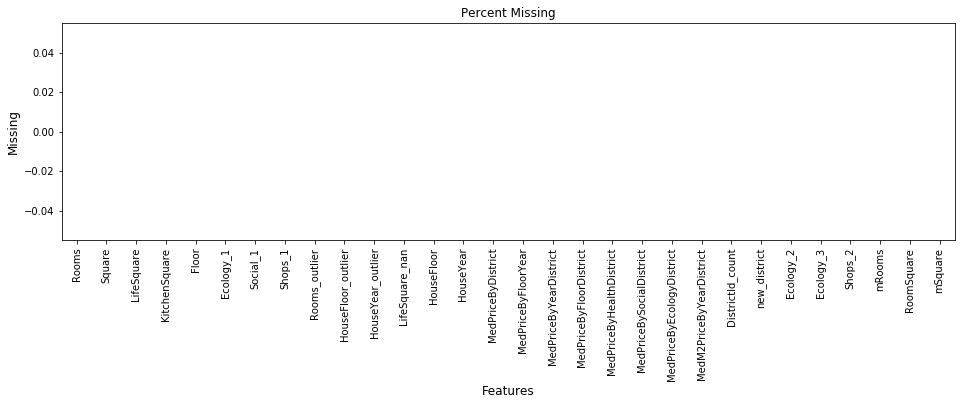

In [63]:
import seaborn as sns

nan_df = (X.isna().sum() / X.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [64]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   10000 non-null  float64
dtypes: float64(1)
memory usage: 78.2 KB


In [65]:
y.head()

,Price
0,184966.930730
1,300009.450063
2,220925.908524
3,175616.227217
4,150226.531644


In [66]:
y['Price'].head()

0    184966.930730
1    300009.450063
2    220925.908524
3    175616.227217
4    150226.531644
Name: Price, dtype: float64

# 4. Модель

In [67]:
model = GradientBoostingRegressor(max_depth=5, min_samples_leaf=12,n_estimators=110, random_state=42)
#model = RandomForestRegressor(max_depth=8, min_samples_leaf=10,n_estimators=300, random_state=42)


cv_score = cross_val_score(model, X, y['Price'], scoring='r2', error_score=0, cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.804 +- 0.012


In [68]:
# Обучаю модель на всем трейне
model.fit(X, y['Price'])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=12, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=110,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

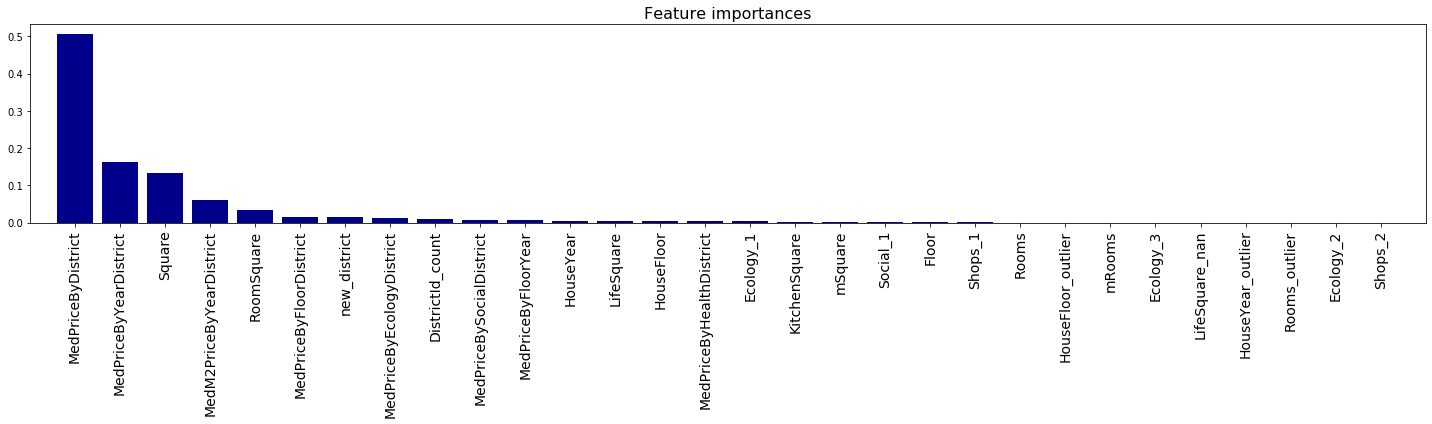

In [69]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = model.feature_importances_, X=X)

In [70]:
y_pred_final = model.predict(X_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions.csv', index=False)

preds_final.head()

,Id,Price
0,725,166298.740058
1,15856,230849.531262
2,5480,166154.006321
3,15664,266200.725116
4,14275,142587.101916


In [71]:
preds_final.shape

(5000, 2)